# Labo III
# Multinacional - Prediccion de Ventas

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Optional for larger text and better visuals
sns.set(style="whitegrid", context="talk")

In [2]:
# Load the sales data (tab-delimited)
sales = pd.read_csv("../datasets/sell-in.txt", sep="\t", dtype={"periodo": str})

# Load the stocks data (tab-delimited)
stocks = pd.read_csv("../datasets/tb_stocks.txt", sep="\t", dtype={"periodo": str})

# Load the product information data (tab-delimited)
product_info = pd.read_csv("../datasets/tb_productos.txt", sep="\t")

In [3]:
sales['periodo'] = pd.to_datetime(sales['periodo'], format='%Y%m')
stocks['periodo'] = pd.to_datetime(stocks['periodo'], format='%Y%m')

In [4]:
# MONTHLY SALES

# Group by month and product, summing total sales in tons
monthly_sales = (
    sales.groupby(['periodo', 'product_id','customer_id'])['tn']
    .sum()
    .reset_index()
)


# Dealing with zeros

In [5]:
# Ordenar el DataFrame por periodo, product_id y customer_id
monthly_sales = monthly_sales.sort_values(['periodo', 'product_id', 'customer_id'])

# Crear un DataFrame con todas las combinaciones posibles de periodo, product_id y customer_id
all_periods = monthly_sales['periodo'].drop_duplicates()
all_products = monthly_sales['product_id'].drop_duplicates()
all_customers = monthly_sales['customer_id'].drop_duplicates()

full_index = pd.MultiIndex.from_product(
    [all_periods, all_products, all_customers],
    names=['periodo', 'product_id', 'customer_id']
)

# Crear un DataFrame completo con todas las combinaciones
full_sales = pd.DataFrame(index=full_index).reset_index()

# Fusionar con las ventas originales
full_sales = full_sales.merge(monthly_sales, on=['periodo', 'product_id', 'customer_id'], how='left')

# Encontrar la primera y última compra para cada combinación de producto y cliente
first_last_purchase = monthly_sales.groupby(['product_id', 'customer_id']).agg({
    'periodo': ['min', 'max']
}).reset_index()
first_last_purchase.columns = ['product_id', 'customer_id', 'first_purchase', 'last_purchase']

# Fusionar esta información con full_sales
full_sales = full_sales.merge(first_last_purchase, on=['product_id', 'customer_id'], how='left')

# Aplicar la lógica de llenado
def fill_logic(row):
    if pd.isnull(row['tn']):
        if row['periodo'] >= row['first_purchase'] and row['periodo'] <= row['last_purchase']:
            return 0
    return row['tn']

full_sales['tn'] = full_sales.apply(fill_logic, axis=1)

# Eliminar filas donde no hay ventas y están fuera del rango de compra
full_sales = full_sales[
    (~full_sales['tn'].isnull()) | 
    ((full_sales['periodo'] >= full_sales['first_purchase']) & 
     (full_sales['periodo'] <= full_sales['last_purchase']))
]

# Limpiar columnas temporales y ordenar el resultado
full_sales = full_sales.drop(['first_purchase', 'last_purchase'], axis=1)
full_sales = full_sales.sort_values(['periodo', 'product_id', 'customer_id'])

# Rellenar los NaN restantes con 0
full_sales['tn'] = full_sales['tn'].fillna(0)

In [8]:
# Merge stock_final into full_sales
data = full_sales.merge(stocks, on=['periodo', 'product_id'], how='left')

# Merge product info (static features)
data = data.merge(product_info, on='product_id', how='left')

In [11]:
data.head()

,periodo,product_id,customer_id,tn,stock_final,cat1,cat2,cat3,brand,sku_size
0,2017-01-01,20001,10001,99.43861,NaN,HC,ROPA LAVADO,Liquido,ARIEL,3000.0
1,2017-01-01,20001,10002,35.72806,NaN,HC,ROPA LAVADO,Liquido,ARIEL,3000.0
2,2017-01-01,20001,10003,143.49426,NaN,HC,ROPA LAVADO,Liquido,ARIEL,3000.0
3,2017-01-01,20001,10004,184.72927,NaN,HC,ROPA LAVADO,Liquido,ARIEL,3000.0
4,2017-01-01,20001,10005,19.08407,NaN,HC,ROPA LAVADO,Liquido,ARIEL,3000.0


C:\Users\s1093678\AppData\Local\Temp\ipykernel_8640\1670790635.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['periodo'] = pd.to_datetime(filtered_df['periodo'])


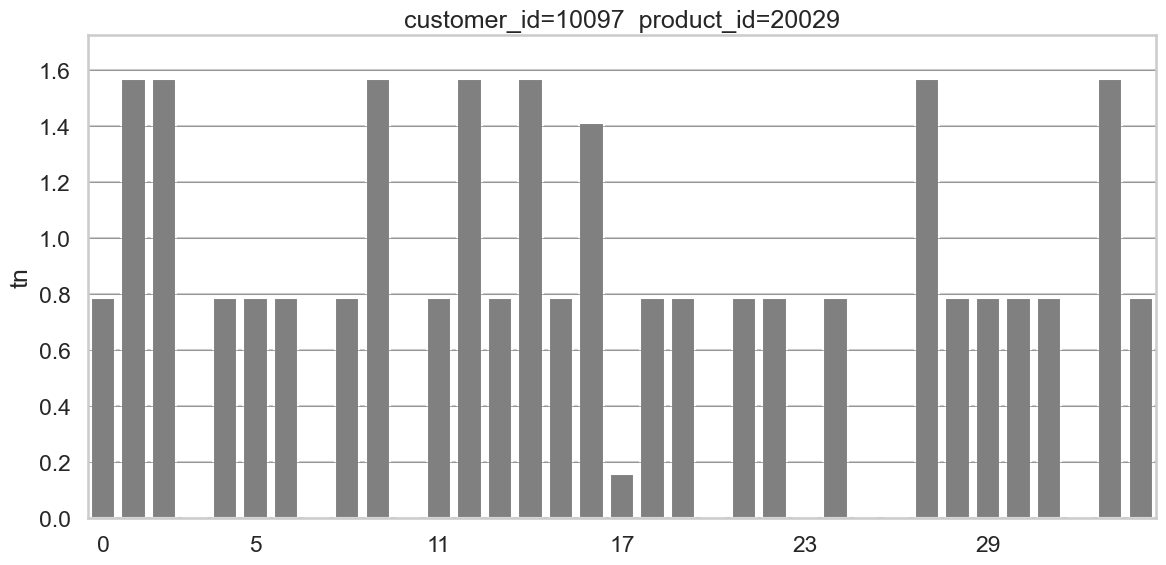

In [12]:
customer_id = 10097
product_id = 20029

filtered_df = data[(data['customer_id'] == customer_id) & (data['product_id'] == product_id)]

# Convert 'periodo' to datetime if it's not already
filtered_df['periodo'] = pd.to_datetime(filtered_df['periodo'])

# Sort the DataFrame by date
filtered_df = filtered_df.sort_values('periodo')

# Reset index to get a range index for x-axis
filtered_df = filtered_df.reset_index(drop=True)

# Create the plot
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")
ax = sns.barplot(x=filtered_df.index, y='tn', data=filtered_df, color='gray')

# Customize the plot
plt.title(f'customer_id={customer_id}  product_id={product_id}')
plt.xlabel('')
plt.ylabel('tn')

# Remove x-axis labels
plt.xticks([])

# Add x-axis ticks at 0 and every 6th position
x_ticks = [0] + list(range(5, len(filtered_df), 6))
plt.xticks(x_ticks, [str(x) for x in x_ticks])

# Set y-axis limits
plt.ylim(0, filtered_df['tn'].max() * 1.1)  # Set the upper limit to 110% of the max value

# Add horizontal lines
for y in np.arange(0.2, plt.ylim()[1], 0.2):
    plt.axhline(y=y, color='gray', linestyle='-', linewidth=0.5)

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
data.head()

,periodo,product_id,customer_id,tn,stock_final,cat1,cat2,cat3,brand,sku_size
0,2017-01-01,20001,10001,99.43861,NaN,HC,ROPA LAVADO,Liquido,ARIEL,3000.0
1,2017-01-01,20001,10002,35.72806,NaN,HC,ROPA LAVADO,Liquido,ARIEL,3000.0
2,2017-01-01,20001,10003,143.49426,NaN,HC,ROPA LAVADO,Liquido,ARIEL,3000.0
3,2017-01-01,20001,10004,184.72927,NaN,HC,ROPA LAVADO,Liquido,ARIEL,3000.0
4,2017-01-01,20001,10005,19.08407,NaN,HC,ROPA LAVADO,Liquido,ARIEL,3000.0


# Adding some random columns



In [13]:
data.head()

,periodo,product_id,customer_id,tn,stock_final,cat1,cat2,cat3,brand,sku_size
0,2017-01-01,20001,10001,99.43861,NaN,HC,ROPA LAVADO,Liquido,ARIEL,3000.0
1,2017-01-01,20001,10002,35.72806,NaN,HC,ROPA LAVADO,Liquido,ARIEL,3000.0
2,2017-01-01,20001,10003,143.49426,NaN,HC,ROPA LAVADO,Liquido,ARIEL,3000.0
3,2017-01-01,20001,10004,184.72927,NaN,HC,ROPA LAVADO,Liquido,ARIEL,3000.0
4,2017-01-01,20001,10005,19.08407,NaN,HC,ROPA LAVADO,Liquido,ARIEL,3000.0


In [14]:
import pandas as pd
import numpy as np

# Assuming your DataFrame is named 'data'

# 1. Time-based features
data['year'] = data['periodo'].dt.year
data['month'] = data['periodo'].dt.month
data['quarter'] = data['periodo'].dt.quarter
data['day_of_week'] = data['periodo'].dt.dayofweek
data['is_weekend'] = data['day_of_week'].isin([5, 6]).astype(int)
data['is_month_start'] = data['periodo'].dt.is_month_start.astype(int)
data['is_month_end'] = data['periodo'].dt.is_month_end.astype(int)

# 2. Lag features
for lag in [1, 2, 3, 6, 12]:
    data[f'sales_lag_{lag}'] = data.groupby(['product_id', 'customer_id'])['tn'].shift(lag)

# 3. Rolling statistics
for window in [3, 6, 12]:
    data[f'sales_rolling_mean_{window}'] = data.groupby(['product_id', 'customer_id'])['tn'].transform(lambda x: x.rolling(window=window, min_periods=1).mean())
    data[f'sales_rolling_std_{window}'] = data.groupby(['product_id', 'customer_id'])['tn'].transform(lambda x: x.rolling(window=window, min_periods=1).std())

# 4. Cumulative features
data['cumulative_sales'] = data.groupby(['product_id', 'customer_id'])['tn'].cumsum()

# 5. Categorical encoding
data['product_customer_combined'] = data['product_id'].astype(str) + '_' + data['customer_id'].astype(str)

# 6. Seasonality features
data['sin_month'] = np.sin(2 * np.pi * data['month'] / 12)
data['cos_month'] = np.cos(2 * np.pi * data['month'] / 12)

# 7. Product and customer aggregations
product_aggs = data.groupby('product_id')['tn'].agg(['mean', 'std', 'max']).add_prefix('product_')
customer_aggs = data.groupby('customer_id')['tn'].agg(['mean', 'std', 'max']).add_prefix('customer_')

data = data.merge(product_aggs, on='product_id', how='left')
data = data.merge(customer_aggs, on='customer_id', how='left')

# 8. Relative features
data['sales_relative_to_product_mean'] = data['tn'] / data['product_mean']
data['sales_relative_to_customer_mean'] = data['tn'] / data['customer_mean']

# 9. Stock-related features (if stock_final is available)
if 'stock_final' in data.columns:
    data['stock_turnover'] = data['tn'] / data['stock_final']
    data['days_of_stock'] = data['stock_final'] / (data['tn'] / 30)  # Assuming 'tn' is monthly sales

# 10. Category-based features (if available)
for cat in ['cat1', 'cat2', 'cat3']:
    if cat in data.columns:
        data[f'{cat}_avg_sales'] = data.groupby(cat)['tn'].transform('mean')

# 11. Brand-based features (if available)
if 'brand' in data.columns:
    data['brand_avg_sales'] = data.groupby('brand')['tn'].transform('mean')

# 12. Size-based features (if available)
if 'sku_size' in data.columns:
    data['size_avg_sales'] = data.groupby('sku_size')['tn'].transform('mean')

# 13. Trend features
data['sales_diff'] = data.groupby(['product_id', 'customer_id'])['tn'].diff()
data['sales_pct_change'] = data.groupby(['product_id', 'customer_id'])['tn'].pct_change()

# 14. Frequency-based features
data['purchase_frequency'] = data.groupby(['product_id', 'customer_id'])['periodo'].transform('count')

# 15. Recency features
data['days_since_first_purchase'] = (data['periodo'] - data.groupby(['product_id', 'customer_id'])['periodo'].transform('min')).dt.days
data['days_since_last_purchase'] = (data['periodo'] - data.groupby(['product_id', 'customer_id'])['periodo'].transform('max')).dt.days

# Handle potential infinite values
data = data.replace([np.inf, -np.inf], np.nan)

# Fill NaN values
data = data.fillna(0)

In [16]:
data.head()

,periodo,product_id,customer_id,tn,stock_final,cat1,cat2,cat3,brand,sku_size,...,cat1_avg_sales,cat2_avg_sales,cat3_avg_sales,brand_avg_sales,size_avg_sales,sales_diff,sales_pct_change,purchase_frequency,days_since_first_purchase,days_since_last_purchase
0,2017-01-01,20001,10001,99.43861,0.0,HC,ROPA LAVADO,Liquido,ARIEL,3000.0,...,0.515697,0.830332,0.692172,0.842301,1.38321,0.0,0.0,36,0,-1064
1,2017-01-01,20001,10002,35.72806,0.0,HC,ROPA LAVADO,Liquido,ARIEL,3000.0,...,0.515697,0.830332,0.692172,0.842301,1.38321,0.0,0.0,36,0,-1064
2,2017-01-01,20001,10003,143.49426,0.0,HC,ROPA LAVADO,Liquido,ARIEL,3000.0,...,0.515697,0.830332,0.692172,0.842301,1.38321,0.0,0.0,36,0,-1064
3,2017-01-01,20001,10004,184.72927,0.0,HC,ROPA LAVADO,Liquido,ARIEL,3000.0,...,0.515697,0.830332,0.692172,0.842301,1.38321,0.0,0.0,36,0,-1064
4,2017-01-01,20001,10005,19.08407,0.0,HC,ROPA LAVADO,Liquido,ARIEL,3000.0,...,0.515697,0.830332,0.692172,0.842301,1.38321,0.0,0.0,36,0,-1064
